# A demonstration of the ROAD benchmark

In this short tutorial notebook, we will use the ROAD (Remove and Debias) Benchmark for feature attributions to assess the faithfulness of Integrated Gradient (IG) attributions on the CIFAR-10 dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import torchvision
from torchvision import models as models
import torchvision.transforms as transforms
from torch import nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: A walkthrough to ROAD

This section introduces the basic interface to run the ROAD benchmark.

In [3]:
import road
from road import run_road, set_device

In [4]:
set_device("cpu") # Set execution device for the ROAD benchmark. 
print("Using device", road.use_device, "for ROAD.")

Using device cpu for ROAD.


### 1. Load the data and the corresponding attribution maps

We provide sample maps for CIFAR 10 that can be loaded on our GoogleDrive for the Integrated Gradients Explanation technique. Please find them at https://drive.google.com/drive/folders/1g0nXL1i1m_s4j-QF7Qx9gkOnxcN0FvBS?usp=sharing.
Download the file ``base_test.pkl`` to the folder ``data/``.

In [5]:
from road.utils import load_expl
_, explanation_test, _, prediction_test = load_expl(None, 'data/base_test.pkl')

In [6]:
transform_tensor = torchvision.transforms.Compose([transforms.ToTensor()])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_tensor)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_tensor)
print("Length of test set: ", len(cifar_test))

Files already downloaded and verified
Files already downloaded and verified
Length of test set:  10000


In [7]:
def show_img(ax, dataset, iid, attributions=False):
    """ Plot an item of a dataset. Tranfer axis format from channels-first to channels-last."""
    tup = dataset[iid]
    if attributions:
        ax.matshow(np.linalg.norm(tup, axis=2))
    else:
        ax.imshow((tup[0].cpu().transpose(0,1).transpose(1,2)))

Plot an example image and the corresponding attribution.

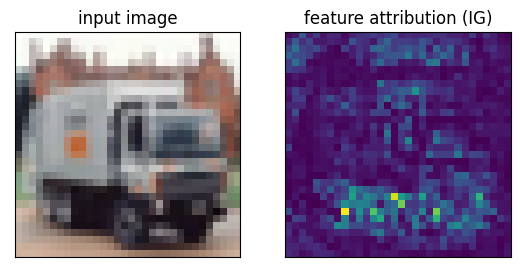

In [8]:
f, axes_list = plt.subplots(1, 2)
img_id = 11
show_img(axes_list[0], cifar_test, img_id)
axes_list[0].set_title("input image")

show_img(axes_list[1], explanation_test, img_id, attributions=True)
axes_list[1].set_title("feature attribution (IG)")

for ax in axes_list:
    ax.set_xticks([])
    ax.set_yticks([])

### 2. Load the trained model

As a second step, a trained model is required. This should be the same model, the explanations were computed with. We also provide a trained model (ResNet-18) for the CIFAR-10 dataset.

In [9]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(road.use_device)
# load trained classifier
model.load_state_dict(torch.load('data/cifar_8014.pth', map_location=road.use_device))

# This transform has to be performed to the tensor data to run this model.
transform_test = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

For the ROAD benchmark, the Dataset objects should return non-normalized Tensors.

### 3. Run the ROAD Benchmark

In [10]:
# the exact percentages used in our runtime benchmarks. We used the same values for ROAR.
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
from road.imputations import NoisyLinearImputer, ZeroImputer, GAINImputer, ChannelMeanImputer, ImpaintingImputation

The inferface to run the benchmark:

In [11]:
?run_road

Signature:
run_road(
    model,
    dataset_test,
    explanations_test,
    transform_test,
    percentages,
    morf=True,
    batch_size=64,
    imputation=<road.imputations.NoisyLinearImputer object at 0x7f47c609d940>,
    threshold=False,
)
Docstring:
Run the ROAD benchmark. 
model: Pretrained model on data set.
dataset_test: The test set to run the benchmark on. Should deterministically return a (tensor, tensor)-tuple for each index.
explanations_test: Attributions for each data point. List or array (or any SupportsIndex) with same len as dataset_test.
transform_test: Transforms to be applied on the Modified data set after the imputation, e.g. normalization. Transformations applied before imputation should
    already be incorporated into dataset_test.
percentages: List of percentage values that will be tested.
morf: True, if morf oder should be applied, else false.
batch_size: Batch size to use for the benchmark. Can be larger as it does inference only.
imputation: Either an Imp

In [12]:

%%time
accuracies_road, probs = run_road(model, cifar_test, explanation_test, transform_test, percentages, morf=True, imputation=ImpaintingImputation() )

Running evaluation for p= 0.1
Accuracy of the network on test images: 68.9100 %, average probability:  0.1029
Running evaluation for p= 0.2
Accuracy of the network on test images: 61.9200 %, average probability:  0.1017
Running evaluation for p= 0.3
Accuracy of the network on test images: 56.7500 %, average probability:  0.1023
Running evaluation for p= 0.4
Accuracy of the network on test images: 52.8100 %, average probability:  0.1017
Running evaluation for p= 0.5
Accuracy of the network on test images: 50.0200 %, average probability:  0.1000
Running evaluation for p= 0.6
Accuracy of the network on test images: 47.3700 %, average probability:  0.0959
Running evaluation for p= 0.7
Accuracy of the network on test images: 44.0100 %, average probability:  0.0938
Running evaluation for p= 0.8
Accuracy of the network on test images: 39.9200 %, average probability:  0.0940
Running evaluation for p= 0.9
Accuracy of the network on test images: 31.6800 %, average probability:  0.0953
CPU times:

A first plot of the results.

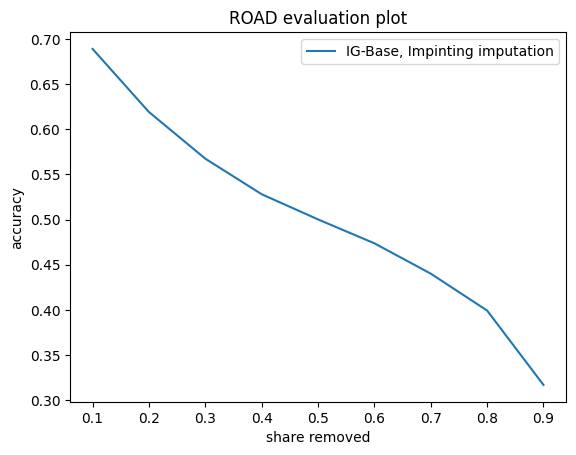

In [13]:
plt.plot(percentages, accuracies_road, label="IG-Base, Impinting imputation")
#plt.plot(percentages, accuracies_gain, label="IG-Base, GAIN")
plt.xlabel("share removed")
plt.ylabel("accuracy")
plt.title("ROAD evaluation plot")
plt.legend()

In [14]:
%%time
accuracies_road_lerf, probs = run_road(model, cifar_test, explanation_test, transform_test, percentages, morf=False, imputation= ImpaintingImputation())

Running evaluation for p= 0.1
Accuracy of the network on test images: 48.1900 %, average probability:  0.1102
Running evaluation for p= 0.2
Accuracy of the network on test images: 66.4300 %, average probability:  0.0983
Running evaluation for p= 0.3
Accuracy of the network on test images: 74.2700 %, average probability:  0.0955
Running evaluation for p= 0.4
Accuracy of the network on test images: 77.9000 %, average probability:  0.0963
Running evaluation for p= 0.5
Accuracy of the network on test images: 79.2300 %, average probability:  0.0962
Running evaluation for p= 0.6
Accuracy of the network on test images: 80.4700 %, average probability:  0.0975
Running evaluation for p= 0.7
Accuracy of the network on test images: 81.5600 %, average probability:  0.0975
Running evaluation for p= 0.8
Accuracy of the network on test images: 81.5800 %, average probability:  0.0986
Running evaluation for p= 0.9
Accuracy of the network on test images: 81.7200 %, average probability:  0.0990
CPU times:

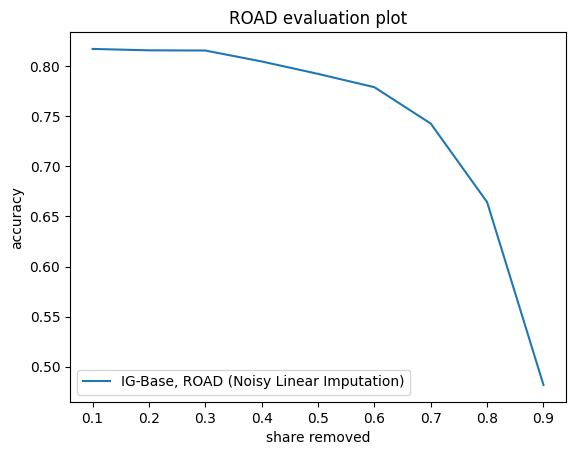

In [15]:
accuracies_road = accuracies_road_lerf.tolist()

accuracies_road.reverse()
plt.plot(percentages, accuracies_road, label="IG-Base, ROAD (Noisy Linear Imputation)")
#plt.plot(percentages, accuracies_gain, label="IG-Base, GAIN")
plt.xlabel("share removed")
plt.ylabel("accuracy")
plt.title("ROAD evaluation plot")
plt.legend()

## Part 2: Some more tricks and how to set up a custom modified data set

Now that the basic interface is in place, we will show how to use and visualize the different imputers, that are implemented in the ``road.imputations`` sub-package.
We set up a data set based on CIFAR 10, with 10/30/50/70/90 percent of most important pixels removed.

First, we import and initialize the imputers.

In [16]:
# Import the imputers.
from road.imputations import NoisyLinearImputer, ZeroImputer, GAINImputer, ChannelMeanImputer, ImpaintingImputation
# The Noisy Linear Imputer derived in the paper. This is the default imputer of ROAD.
method_linear = NoisyLinearImputer(noise=0.01)

# Additionally, we can impute with zeros.
method_fixed = ZeroImputer()

# Or we can use a trained GAIN (Generative Imputation Networks, see Yoon et al.)
# We provied a GAIN model for Cifar 10 in the repository. The device specified will be used to run the GAN inference algorithm.
#method_gain = GAINImputer("road/gisp/models/cifar_10_best.pt", use_device="cuda:0") # Using "cpu" here is possible but will be considerably slower when running the benchmark. 

The ```ImputedDataset``` class can be used to apply an imputer ontop of an existing dataset.

**A word on transformations:** Before an image can be used as an input to a CV model, several transformations are usually applied (e.g., Image -> Tensor, Cropping, Tensor Normalization, etc.). The imputation according to the explanantion map can be seen as another step in the transformation chain. To specify after which transformation it is applied, the chain of transformations is split up in two. The first part of the transformations (usally the Image -> Tensor, Cropping) is passed to the base dataset, on top of which the Imputation is applied by the ```ImputedDataset``` class. Transformations such as normalizations that are applied after imputation (see the ```transforms_test``` argument in the earlier example) can be passed to the ImputedDataset class (via its ```transform``` argument or to the ```run_road``` function, which calls this constructor.

In [17]:
from road import ThresholdDataset, ImputedDataset

Let's visualize an example of how the imputations look like on CIFAR-10:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


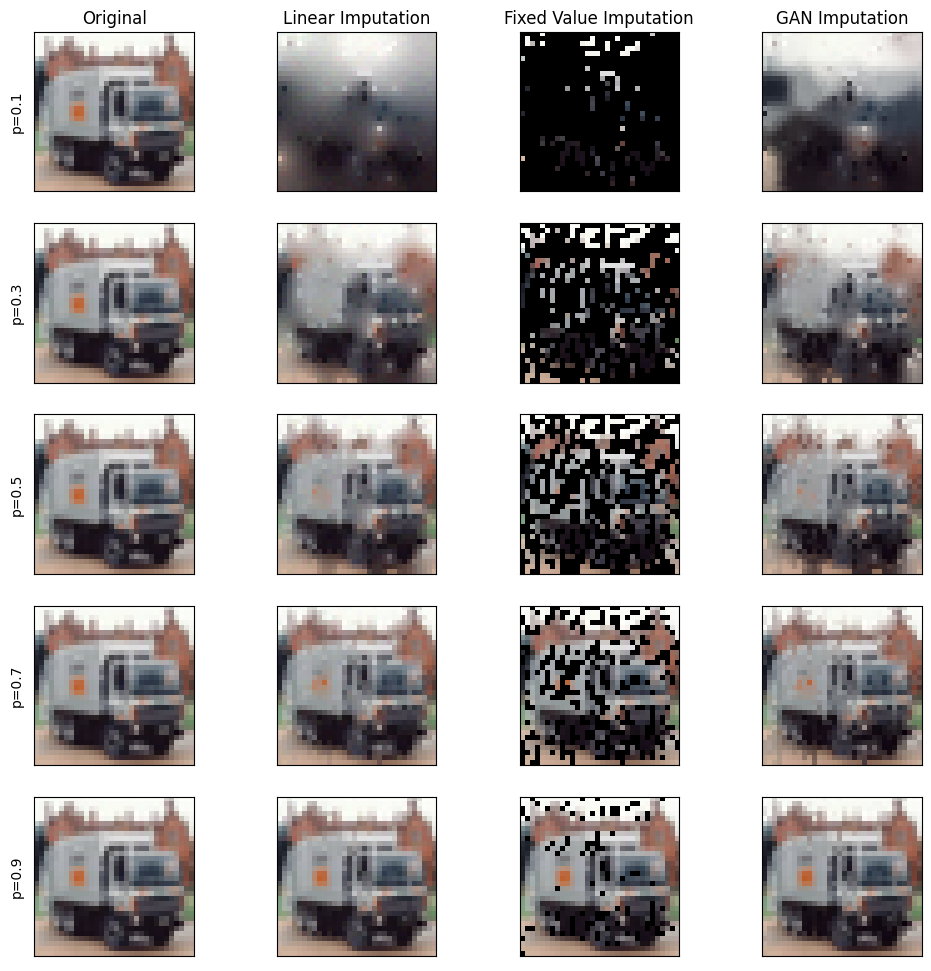

In [18]:
image_id=11 # Choose any image ID you like here.

percentage_imputed = [0.1, 0.3, 0.5, 0.7, 0.9]
f, ax_arr = plt.subplots(len(percentage_imputed), 4)

for k, p in enumerate(percentage_imputed):
    # Create ImputedDatasets from the cifar_test test set. In this example, we apply no transforms after the imputation, because we want to visualize the images.
    ds_test_imputed_lin = ImputedDataset(cifar_test, mask=explanation_test, th_p=p, remove=False, imputation = method_linear)
    ds_test_imputed_fix =  ImputedDataset(cifar_test, mask=explanation_test, th_p=p, remove=False, imputation = method_fixed)
    ds_test_imputed_gain =  ImputedDataset(cifar_test, mask=explanation_test, th_p=p, remove=False, imputation = ImpaintingImputation())
   
    # Show the original.
    show_img(ax_arr[k][0], cifar_test, image_id)
    ax_arr[k][0].set_ylabel(f"p={p}")
    
    # Show the imputed image.
    show_img(ax_arr[k][1], ds_test_imputed_lin, image_id)
    show_img(ax_arr[k][2], ds_test_imputed_fix, image_id)
    show_img(ax_arr[k][3], ds_test_imputed_gain, image_id)
    
    for j in range(4):
        ax_arr[k][j].set_xticks([])
        ax_arr[k][j].set_yticks([])
ax_arr[0][0].set_title("Original")
ax_arr[0][2].set_title("Fixed Value Imputation")
ax_arr[0][1].set_title("Linear Imputation")
ax_arr[0][3].set_title("GAN Imputation")
plt.gcf().set_size_inches(12,12)

### Run the ROAD Benchmark with the GAN imputer.

In this section, we will run the ROAD benchmark with the GAIN imputer and compare the results. To this end, we use the same arguments as before apart from the ```imputation``` argument, where we now use the ```GAINImputer``` object defined above.

In [19]:
%%time
accuracies_gain, probs = run_road(model, cifar_test, explanation_test, transform_test, 
                                  percentages, morf=True, imputation = NoisyLinearImputer())

Running evaluation for p= 0.1
Accuracy of the network on test images: 71.3300 %, average probability:  0.0994
Running evaluation for p= 0.2
Accuracy of the network on test images: 66.1400 %, average probability:  0.0975
Running evaluation for p= 0.3
Accuracy of the network on test images: 61.0600 %, average probability:  0.0964
Running evaluation for p= 0.4
Accuracy of the network on test images: 57.0900 %, average probability:  0.0960
Running evaluation for p= 0.5
Accuracy of the network on test images: 53.8000 %, average probability:  0.0937
Running evaluation for p= 0.6
Accuracy of the network on test images: 50.0500 %, average probability:  0.0921
Running evaluation for p= 0.7
Accuracy of the network on test images: 45.0300 %, average probability:  0.0895
Running evaluation for p= 0.8
Accuracy of the network on test images: 38.2700 %, average probability:  0.0902
Running evaluation for p= 0.9
Accuracy of the network on test images: 28.9400 %, average probability:  0.0945
CPU times:

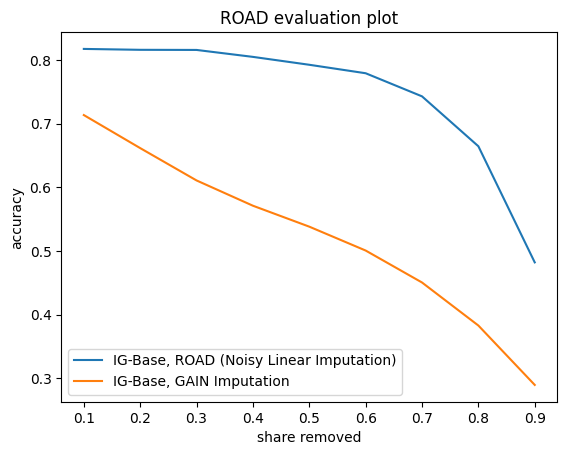

In [20]:
plt.plot(percentages, accuracies_road, label="IG-Base, ROAD (Noisy Linear Imputation)")
plt.plot(percentages, accuracies_gain, label="IG-Base, GAIN Imputation")
plt.xlabel("share removed")
plt.ylabel("accuracy")
plt.title("ROAD evaluation plot")
plt.legend()

Observation: The GAN model retains an increased accurarcy for most percentages but also fails to impute, when many pixels (such as 90%) are removed. Because the GAN model also requires training and has a huge number of hyperparameters to tune, we argue that using the *Noisy Linear Imputation* is the best way to go in most cases (confer our paper for a more profound discussion).

## Conclusion

We have now demonstrated how to use the ROAD benchmark to assess feature attributions. 
We hope this demo notebook will allow you to use and adapt the ROAD Evaluation Strategy to your personal needs. 
Thank you for your interest in our work. If you have further questions or found bugs, don't hesitate to open a GitHub issue or send us a mail. 

The implementation of GAIN used in this work was borrowed from https://github.com/mkachuee/GenerativeImputationStochasticPrediction, which we would like to acknowledge.

The authors, July 2022